<a href="https://colab.research.google.com/github/QuantumNews/Quantum-Algorithm-development/blob/main/12_node_max_cut_QAOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install qiskit

     |████████████████████████████████| 8.5MB 6.1MB/s 
     |████████████████████████████████| 17.6MB 241kB/s 
     |████████████████████████████████| 204kB 43.8MB/s 
     |████████████████████████████████| 204kB 45.3MB/s 
     |████████████████████████████████| 2.1MB 40.4MB/s 
     |████████████████████████████████| 1.0MB 36.6MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 194kB 44.5MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 583kB 47.0MB/s 
     |████████████████████████████████| 3.2MB 39.4MB/s 
     |████████████████████████████████| 5.5MB 21.4MB/s 
  Created wheel for qiskit: filename=qiskit-0.24.0-cp37-none-any.whl size=2918 sha256=d4886f41b0e6da5a2371130ee31b37106a0dd8d6c2e086492049a6f528593e57
  Stored in directory: /root/.cache/pip/wheels/22/fe/0a/26b7a409d1a9c3698b0319c7d009a97bffaae392d755158dca
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2

Problem statement:

Formally stated, for a given graph a maximum cut is a cut whose size is at least the size of any other cut. In other words, the maximum cut is a partition of the graph's vertices into two complementary sets (denoted here as S and T), such that the number of edges between the set S and the set T is as large as possible. The problem of finding such a maximum cut is called the Max-Cut Problem.


The aim of this script is to evaluate a Max-Cut problem involing a 12 node graph using a Quantum Algorithm. This is accomplished through an optiization scheme using the Quantum Approximation Optimization Algorithm. 

To do this we investigate the a more general version of the problem called weighted Max-Cut.  Here each edge is associated with a real number, its weight, and the objective is to maximize the total weight of the edges between S and its complement rather than the number of the edges. 

After installing Qiskit packages, we import the following libraries/packages:

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

First step in the process is generating a graph of 12 random nodes:

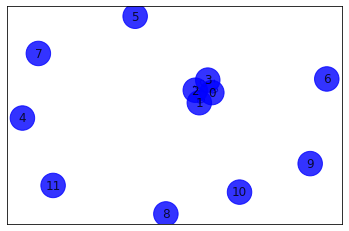

In [ ]:


n=12 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['b' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

We then Compute the weight matrix from the random graph

In [ ]:

w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']

A classical brute force technique can be used as a control study. Here we evaulate the Max-Cut problem for our 12 random node graph.  This is done be defining a cost function using the weight matrix defined in previous step, then optimizing the cost function. As seen bellow this is a tedious technique that can get comutationally expensive as the number of nodes in the graph increases (as 2^n).

In this case we find the best Max-Cut solution seperates graph into the two subgroups (S and T) indicated by the different colours red and blue.

case = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 2.0
case = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 4.0
case = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 2.0
case = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 2.0
case = [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 4.0
case = [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 2.0
case = [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 0.0
case = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [0,

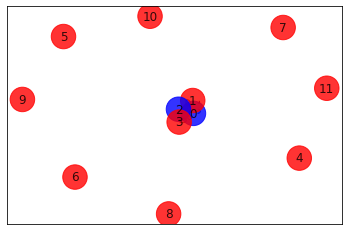

In [ ]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))


To move beyond classical brute force techniques, we implement Qiskit capabilities to map the problem onto the Ising Hamiltonian:

In [ ]:
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: -2.5
Ising Hamiltonian:
IIIIIIIIIIZZ	(0.5+0j)
IIIIIIIIIZIZ	(0.5+0j)
IIIIIIIIIZZI	(0.5+0j)
IIIIIIIIZIIZ	(0.5+0j)
IIIIIIIIZZII	(0.5+0j)



this is done by mapping the Ising Hamiltonina generated above to a quandratic program (denoted qp):

In [ ]:
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: -2.5
Ising Hamiltonian:
IIIIIIIIIIZZ	(0.5+0j)
IIIIIIIIIZIZ	(0.5+0j)
IIIIIIIIIZZI	(0.5+0j)
IIIIIIIIZIIZ	(0.5+0j)
IIIIIIIIZZII	(0.5+0j)



In [ ]:
# mapping Ising Hamiltonian to Quadratic Program
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;
dvar bool x_9;
dvar bool x_10;
dvar bool x_11;

minimize
 [ - 3 x_0^2 + 2 x_0*x_1 + 2 x_0*x_2 + 2 x_0*x_3 - 2 x_1^2 + 2 x_1*x_2
 - 3 x_2^2 + 2 x_2*x_3 - 2 x_3^2 ];
 
subject to {

}


The Quadratic Program is then solved using exact classical eigensolver. As shown below, the same optimal cost function value as before is found.

In [ ]:

exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

optimal function value: -4.0
optimal value: [1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0.]
status: SUCCESS


energy: -1.5
max-cut objective: -4.0
solution: [0 1 0 1 0 0 0 1 0 1 0 1]
solution objective: 4.0


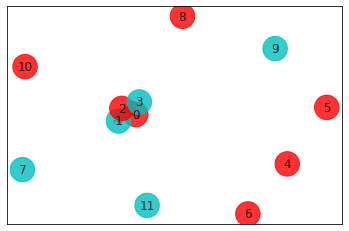

In [ ]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
draw_graph(G, colors, pos)

Max-Cut problem on a quantum comuter:

The optimization routine consists of a feedback loop on a quantum computer using the varaiables derived through classical means explained above.

Trial functions are constructed from  single-qubit Y rotations and entangler gates (Cx)


The algorithm works as follows:



1.   Choose the wi and wij in the target Ising problem. Weight matrix values already obtained in above classical steps.
2.   Choose the depth of the quantum circuit m. Note that the depth can be modified adaptively.
3.   Quantum circuit invovles Simultaneous Perturbation Stochastic Approximation optimizer (SPSA) and a Quantum Variational Eignesolver.
4.   Optimize the outcomes based on expected cost fucntion obtained from classical brute force steps.
5.   repeat iteratively unti cost value function converges to optimial value. 

*note we are only using the statevector_simulator and not executing this program on an actual QPU. 


|


In [ ]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

This part of the protocol deals with the definiation of parametsrs used in the QVE. AS shown below, we use a Simultaneous Perturbation Stochastic Approximation optimizer (SPSA), linear entanglement through Cz gates and Unitary rotations via Ry gates.

energy: -1.495847999667047
time: 87.13135528564453
max-cut objective: -3.9958479996670473
solution: [1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
solution objective: 4.0


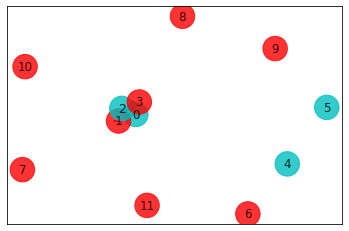

In [ ]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.run(quantum_instance)

# print results
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

# plot results
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
draw_graph(G, colors, pos)

Here we use the minimumEigenOptimizer feature to create minimum optimizer based onthe values obtained from the QVE of above step.  WE do this by usung the quadratic problem defined above.

This final step is the optmizationn problem that gives our final result for the Max-Cut of the 12 node graph. As shown bellow, the cut (seperating sub graphs- vertices of different colours), as well as the optimal function value obtained form the optimization step are identicle to that obtained from the brute force technique discribed above. 

optimal function value: -4.0
optimal value: [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
status: SUCCESS


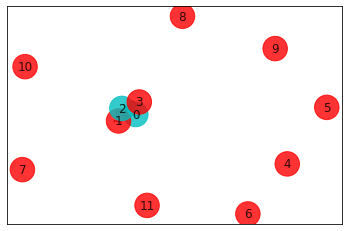

In [ ]:

vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

colors = ['r' if result.x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)